In [27]:
#imports
!pip install ultralytics -q
from ultralytics import YOLO
import os
import pandas as pd
from glob import glob
import cv2
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
import shutil
import yaml
from IPython.display import Image
from datetime import datetime

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [28]:
#configure wandb
WANDB_API_KEY = "90273711258033b1795bf26be0ad04af26b76bb8"
wandb.login(key=WANDB_API_KEY)
wandb.init(project="Animal Type Detection")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [29]:
#download dataset
os.makedirs('animal_type_dataset', exist_ok=True)
!git clone -b animal_type_detection_dataset https://github.com/MVet-Platform/M-Vet_Hackathon24.git ./animal_type_dataset 

fatal: destination path './animal_type_dataset' already exists and is not an empty directory.


In [30]:
#load label data
df = pd.read_csv('/kaggle/working/animal_type_dataset/label_train.csv')
df.head()

filename class  xmin  ymin  xmax  \
0  cb3854ef-2abc-4d44-bd1f-807a38660c616894251975...   cow     1    54   641   
1  4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e804977089514...   cow   168   128   532   
2  cb279fc1-67a3-413c-b3f8-c0594bf0507a1407359993...   cow   584   310   586   
3  97e0bf2d-4548-4c25-9bd7-5a867b8654153628120299...   cow     7    62   641   
4  747cef5f-e7dc-4657-b0e4-225450446a631015105642...   cow   120    48   530   

   ymax  
0   562  
1   360  
2   312  
3   469  
4   336

In [31]:
df['class'].value_counts(normalize=True)

class
cow     0.704333
pig     0.165376
goat    0.130291
Name: proportion, dtype: float64

In [32]:
df['filename'].duplicated().any()

True

In [33]:
def drawBoundingBoxAroundImage(image_path, bbox, class_):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,0), 2)
    cv2.putText(img, class_, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [34]:
#get file path for image files
df['filepath'] = df.apply(lambda row: glob(f'animal_type_dataset/**/{row.filename}')[0], axis=1)

In [35]:
len(df.filename.unique()), len(df.filepath.unique())

(9808, 9808)

In [36]:
df.head()

filename class  xmin  ymin  xmax  \
0  cb3854ef-2abc-4d44-bd1f-807a38660c616894251975...   cow     1    54   641   
1  4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e804977089514...   cow   168   128   532   
2  cb279fc1-67a3-413c-b3f8-c0594bf0507a1407359993...   cow   584   310   586   
3  97e0bf2d-4548-4c25-9bd7-5a867b8654153628120299...   cow     7    62   641   
4  747cef5f-e7dc-4657-b0e4-225450446a631015105642...   cow   120    48   530   

   ymax                                           filepath  
0   562  animal_type_dataset/0006/cb3854ef-2abc-4d44-bd...  
1   360  animal_type_dataset/0003/4f3cbf08-13cc-4ae9-ba...  
2   312  animal_type_dataset/0006/cb279fc1-67a3-413c-b3...  
3   469  animal_type_dataset/0005/97e0bf2d-4548-4c25-9b...  
4   336  animal_type_dataset/0004/747cef5f-e7dc-4657-b0...

In [37]:
def convert_voc_to_yolo(xmin, ymin, xmax, ymax, img_width=640, img_height=640):
    # Calculate the center of the bounding box
    center_x = (xmin + xmax) / 2.0
    center_y = (ymin + ymax) / 2.0

    # Calculate the width and height of the bounding box
    width = xmax - xmin
    height = ymax - ymin

    # Normalize the values by the dimensions of the image
    center_x /= img_width
    center_y /= img_height
    width /= img_width
    height /= img_height

    return [center_x, center_y, width, height]

In [38]:
df_train, df_valid = train_test_split(df, test_size=0.3, random_state=32)

In [39]:
labels = ['cow', 'goat', 'pig']

In [40]:
os.makedirs('yolo_dataset/train/labels', exist_ok=True)
os.makedirs('yolo_dataset/train/images', exist_ok=True)
train_grouping = df_train.groupby('filepath')
for index, group in enumerate(train_grouping):
    bboxes = group[1].apply(lambda row: [row.xmin, row.ymin, row.xmax, row.ymax] , axis=1).to_list()   
    classes = group[1].apply(lambda row: labels.index(row['class']) , axis=1).to_list() 
    file_path = group[0]
    filename = os.path.basename(file_path)
    with open(f'yolo_dataset/train/labels/{os.path.splitext(filename)[0]}.txt', 'w') as file:
        for class_, bbox in zip(classes, bboxes):
            center_x, center_y, width, height = convert_voc_to_yolo(*bbox)
            file.write(f'{class_} {center_x} {center_y} {width} {height}\n')
    shutil.copy(file_path, 'yolo_dataset/train/images')

In [41]:
os.makedirs('yolo_dataset/valid/labels', exist_ok=True)
os.makedirs('yolo_dataset/valid/images', exist_ok=True)
valid_grouping = df_valid.groupby('filepath')
for index, group in enumerate(valid_grouping):
    bboxes = group[1].apply(lambda row: [row.xmin, row.ymin, row.xmax, row.ymax] , axis=1).to_list()   
    classes = group[1].apply(lambda row: labels.index(row['class']) , axis=1).to_list() 
    file_path = group[0]
    filename = os.path.basename(file_path)
    with open(f'yolo_dataset/valid/labels/{os.path.splitext(filename)[0]}.txt', 'w') as file:
        for class_, bbox in zip(classes, bboxes):
            center_x, center_y, width, height = convert_voc_to_yolo(*bbox)
            file.write(f'{class_} {center_x} {center_y} {width} {height}\n')
    shutil.copy(file_path, 'yolo_dataset/valid/images')

In [42]:
df_sample_submission = pd.read_csv('/kaggle/working/animal_type_dataset/sample_submission.csv')
df_sample_submission.head()

filename class  confidence  xmin  \
0  dc3bf168-1589-486d-8152-438d0e4a56f24141622663...   cow        0.75     0   
1  0691e0da-6b49-414e-a0d9-e6caa2fbe3fa2720742594...   cow        0.75     0   
2  68072e08-d602-4daa-9b2e-b53e3075d45d7996898967...   cow        0.75     0   
3  57f59f63-9ec6-4d0b-b837-808a089f3d876691836245...   cow        0.75     0   
4  7091ebde-40ba-478c-b119-2c558dfe133a8689373316...   cow        0.75     0   

   ymin  xmax  ymax  
0     0     0     0  
1     0     0     0  
2     0     0     0  
3     0     0     0  
4     0     0     0

In [43]:
#get file path for test image files
df_sample_submission['filepath'] = df_sample_submission.apply(lambda row: glob(f'animal_type_dataset/**/{row.filename}')[0], axis=1)
df_sample_submission.head()

filename class  confidence  xmin  \
0  dc3bf168-1589-486d-8152-438d0e4a56f24141622663...   cow        0.75     0   
1  0691e0da-6b49-414e-a0d9-e6caa2fbe3fa2720742594...   cow        0.75     0   
2  68072e08-d602-4daa-9b2e-b53e3075d45d7996898967...   cow        0.75     0   
3  57f59f63-9ec6-4d0b-b837-808a089f3d876691836245...   cow        0.75     0   
4  7091ebde-40ba-478c-b119-2c558dfe133a8689373316...   cow        0.75     0   

   ymin  xmax  ymax                                           filepath  
0     0     0     0  animal_type_dataset/0006/dc3bf168-1589-486d-81...  
1     0     0     0  animal_type_dataset/0001/0691e0da-6b49-414e-a0...  
2     0     0     0  animal_type_dataset/0003/68072e08-d602-4daa-9b...  
3     0     0     0  animal_type_dataset/0003/57f59f63-9ec6-4d0b-b8...  
4     0     0     0  animal_type_dataset/0004/7091ebde-40ba-478c-b1...

In [44]:
test_file_paths = df_sample_submission.filepath.unique()

In [45]:
#create test directory
os.makedirs('yolo_dataset/test/images')
for file_path in test_file_paths:
    shutil.copy(file_path, 'yolo_dataset/test/images')

FileExistsError: [Errno 17] File exists: 'yolo_dataset/test/images'

In [49]:
data = {
'names': labels,
'nc': len(labels),
'test': './test/images',
'train': './train/images',
'val': './valid/images'
}
with open('yolo_dataset/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

In [48]:
#train model
model = YOLO("yolov8n.pt")
model.train(
    data="/kaggle/working/yolo_dataset/data.yaml", 
    epochs=30, 
    imgsz=640, 
    plots=True,
    batch = 64,
    pretrained = True,
    seed = 7,
)

Ultralytics YOLOv8.2.81 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=30, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=7, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

train: Scanning /kaggle/working/yolo_dataset/train/labels.cache... 6889 images, 0 backgrounds, 1 corrupt: 100%|██████████| 6889/6889 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/working/yolo_dataset/train/images/0079ed54-fd41-4be1-a6c6-a6464c1727454559382684559930503_jpg.rf.cd673f9d79a2b02c67ff8282f38c3ce8.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0008]
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_dataset/valid/labels.cache... 2969 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2969/2969 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30        10G       1.29       2.49      1.684        101        640: 100%|██████████| 108/108 [01:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]


                   all       2969       2985      0.463      0.469      0.398      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30        10G      1.317      1.946       1.69         83        640: 100%|██████████| 108/108 [01:01<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.52it/s]


                   all       2969       2985      0.498       0.39      0.364      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30        10G      1.362      1.792      1.712         91        640: 100%|██████████| 108/108 [01:02<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]


                   all       2969       2985      0.458      0.429      0.367      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30        10G      1.372      1.704      1.718        103        640: 100%|██████████| 108/108 [01:02<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:26<00:00,  1.11s/it]

                   all       2969       2985      0.402      0.515      0.426      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30        10G      1.331      1.604      1.678         99        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.55it/s]


                   all       2969       2985      0.487      0.559      0.447       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30        10G      1.307      1.577      1.661         93        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]


                   all       2969       2985      0.541      0.537      0.515      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30        10G      1.282      1.525      1.642         96        640: 100%|██████████| 108/108 [01:07<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]


                   all       2969       2985      0.526      0.548      0.517      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30        10G      1.264      1.502      1.629         95        640: 100%|██████████| 108/108 [01:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]


                   all       2969       2985      0.592      0.593      0.577      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30        10G      1.259      1.459      1.624         94        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]

                   all       2969       2985      0.595      0.613      0.555      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30        10G      1.242      1.444       1.61         78        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.54it/s]


                   all       2969       2985      0.615      0.588      0.627      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30        10G      1.225      1.417      1.595         80        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.54it/s]

                   all       2969       2985      0.645      0.624      0.638      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30        10G      1.205      1.394       1.58         92        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]


                   all       2969       2985      0.571      0.627      0.594      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30        10G      1.196      1.365      1.574         98        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.55it/s]


                   all       2969       2985      0.677       0.66      0.674      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30        10G      1.184      1.362      1.568         89        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]


                   all       2969       2985       0.66      0.672      0.659      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30        10G      1.186      1.338       1.56         81        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]


                   all       2969       2985      0.687      0.663       0.68      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30        10G      1.182      1.333      1.555        101        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]

                   all       2969       2985      0.656      0.689      0.635       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30        10G      1.171      1.315      1.555         93        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.55it/s]

                   all       2969       2985      0.704      0.693      0.711      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30        10G       1.16      1.307      1.539         94        640: 100%|██████████| 108/108 [01:02<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]


                   all       2969       2985      0.707      0.716      0.705      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30        10G      1.145        1.3      1.537         92        640: 100%|██████████| 108/108 [01:07<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]


                   all       2969       2985      0.679      0.672      0.677      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30        10G      1.139      1.272      1.531        102        640: 100%|██████████| 108/108 [01:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.57it/s]

                   all       2969       2985       0.73      0.728       0.75      0.413


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      10.5G      1.184      1.049      1.723         40        640: 100%|██████████| 108/108 [01:04<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.55it/s]


                   all       2969       2985      0.724      0.679      0.713      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30        10G       1.16      1.022      1.707         40        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.56it/s]


                   all       2969       2985      0.731      0.753       0.75      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30        10G      1.155     0.9974      1.696         40        640: 100%|██████████| 108/108 [01:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.58it/s]

                   all       2969       2985      0.718      0.737      0.725      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30        10G      1.141     0.9776      1.692         41        640: 100%|██████████| 108/108 [01:01<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.52it/s]

                   all       2969       2985       0.77      0.727      0.752      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30        10G      1.126     0.9509      1.672         41        640: 100%|██████████| 108/108 [01:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:16<00:00,  1.50it/s]

                   all       2969       2985       0.77       0.75      0.768      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30        10G      1.095     0.9398      1.649         41        640: 100%|██████████| 108/108 [01:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.50it/s]


                   all       2969       2985      0.745      0.755      0.757      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30        10G      1.101     0.9237      1.658         40        640: 100%|██████████| 108/108 [01:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:15<00:00,  1.60it/s]


                   all       2969       2985      0.787      0.756      0.775      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30        10G      1.078     0.9155      1.638         40        640: 100%|██████████| 108/108 [01:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]

                   all       2969       2985      0.781      0.766      0.785      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30        10G      1.067     0.8869      1.628         40        640: 100%|██████████| 108/108 [01:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:26<00:00,  1.10s/it]

                   all       2969       2985       0.78      0.775       0.78      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30        10G      1.061     0.8841      1.621         40        640: 100%|██████████| 108/108 [01:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:21<00:00,  1.10it/s]

                   all       2969       2985      0.791      0.771      0.791      0.469



30 epochs completed in 0.672 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.81 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:20<00:00,  1.15it/s]


                   all       2969       2985      0.791      0.771      0.791      0.469
                   cow       2114       2125      0.855      0.841      0.861      0.526
                  goat        362        363      0.718      0.646      0.682      0.377
                   pig        496        497      0.801      0.825      0.829      0.505
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78f2706d6590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [50]:
#list yolo generated training files
os.listdir("runs/detect/train/")

['results.csv',
 'labels_correlogram.jpg',
 'args.yaml',
 'labels.jpg',
 'val_batch2_pred.jpg',
 'F1_curve.png',
 'P_curve.png',
 'val_batch2_labels.jpg',
 'PR_curve.png',
 'val_batch0_labels.jpg',
 'val_batch0_pred.jpg',
 'val_batch1_labels.jpg',
 'train_batch2.jpg',
 'R_curve.png',
 'confusion_matrix.png',
 'confusion_matrix_normalized.png',
 'results.png',
 'weights',
 'events.out.tfevents.1724419768.00154d2585cf.36.0',
 'train_batch0.jpg',
 'train_batch1.jpg',
 'val_batch1_pred.jpg']

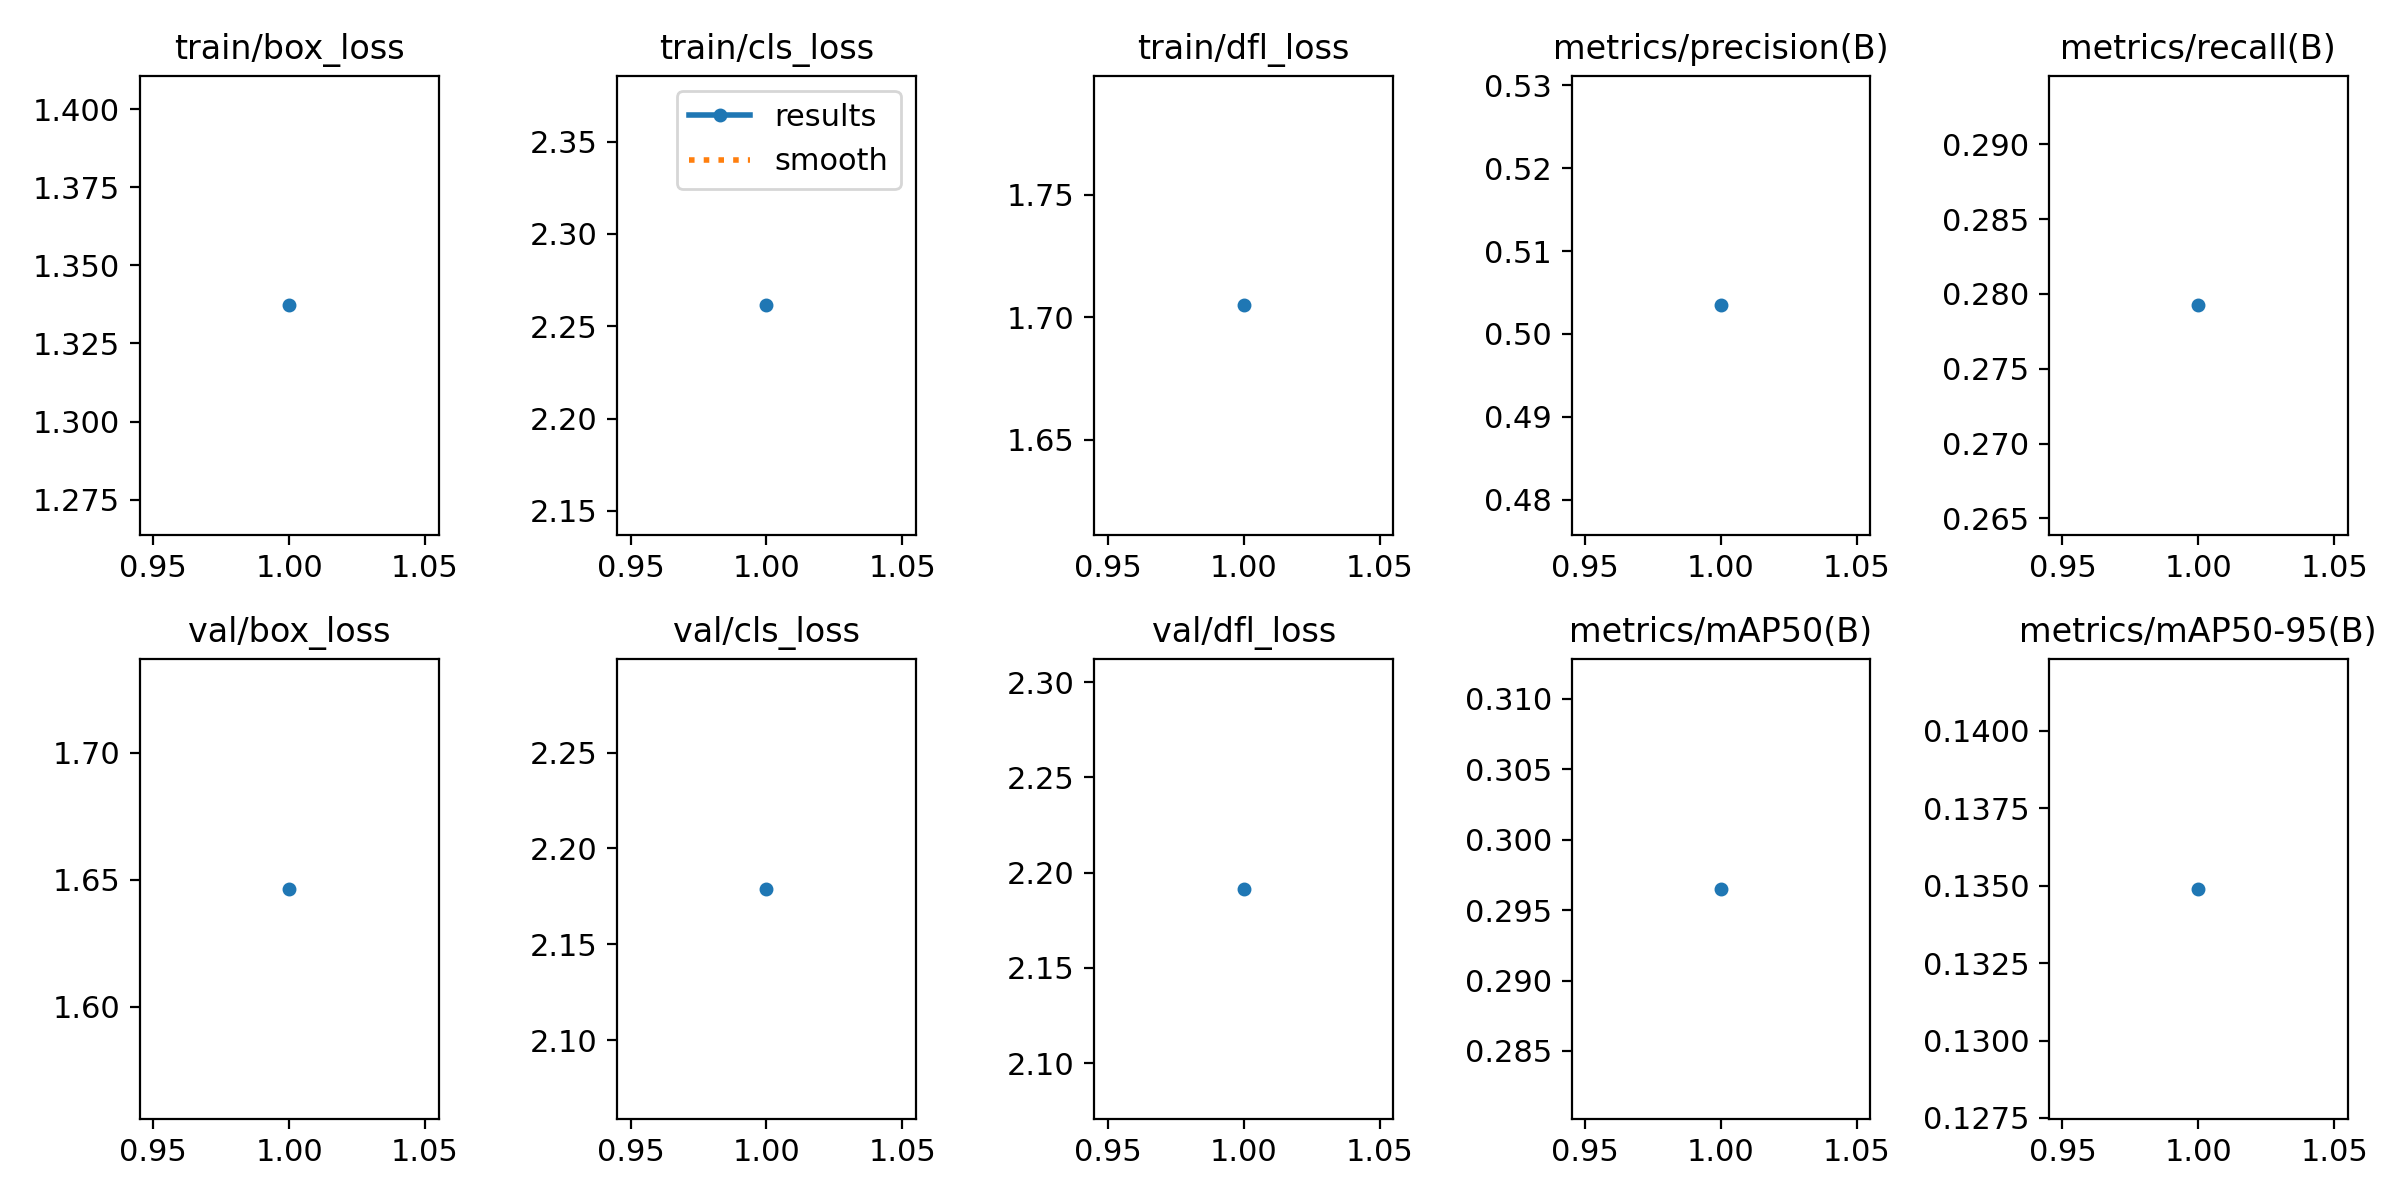

In [51]:
Image(filename='runs/detect/train/results.png', width=600)

In [ ]:
#make predictions
results = model.predict(source='yolo_dataset/test/images', conf=0.25, save=True, project=f"runs/detect", name="predict", exist_ok=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/9811 /kaggle/working/yolo_dataset/test/images/000c4dcc-1dfb-4ba9-b82a-8084b839e02b8229627971783132002_jpg.rf.66f747b7977a2f874959f17a1e0a93a2.jpg: 640x640 1 cow, 9.8ms
image 2/9811 /kaggle/working/yolo_dataset/test/images/00133b56-3901-4a85-a862-004daf4869f7393130629613491919_jpg.rf.63636470b2d9a0e2862cc9fd461f78de.jpg: 640x640 2 cows, 6.4ms
image 3/9811 /kaggle/working/yolo_dataset/test/images/0016844c-8421-4e81-896c-71d6d8a1c91816251043026016

In [54]:
#create submission file
data = []
for result in results:
    image_name = os.path.basename(result.path)
    class_names =result.names
    for box, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        class_name = class_names[int(cls)]
        bbox = box.cpu().tolist()
        record = [image_name, class_name, conf.item()]+bbox
        data.append(record)

with open(f'submission{int(datetime.now().timestamp())}.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    header = ['filename', 'class', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']
    writer.writerow(header)
    writer.writerows(data)